### 필요한 라이브러리 로드

In [1]:
from ultralytics import YOLO
import mediapipe as mp
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import numpy as np
import os
import random
import platform
import yaml
from tqdm import tqdm
import gc
from torch.cuda import empty_cache

if platform.system() == "Darwin":
    print("your system is mac os")
    device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
else:
    print("your system is cuda")
    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

your system is cuda


### YOLO 학습

In [ ]:
data_dir = "/home/pepsi/Downloads/yoloData"
model = "yolov8m.pt"

classes = ['person', 'cigarette']
nc = len(classes)
yaml_file = "data.yaml"

In [3]:
data = {
    "train": data_dir + "/train/",
    "val": data_dir + "/valid/",
    "test": data_dir + "/test/",
    "nc": nc,
    "name": classes
}

In [4]:
os.makedirs(data_dir, exist_ok=True)

with open(data_dir + "/" + yaml_file, 'wt') as fw:
    yaml.dump(data, fw)

In [4]:
training_epochs = 100
patience = 30
batch = 8
imgsz = 640
name = "yolov8_epoch100"

In [3]:
yolo_model = YOLO(model).to(device)

yolo_model.train(data=data_dir + "/" + yaml_file, epochs=training_epochs, patience=patience, batch=batch, imgsz=imgsz, name=name)

NameError: name 'training_epochs' is not defined

In [5]:
yolo_best_model_path = f'/home/pepsi/dev_ws/ros-repo-5/admin/src/ai_server/ai_train/runs/detect/{name}/weights/best.pt'
yolo_best_model = YOLO(yolo_best_model_path).to(device)

metrics = yolo_best_model.val()
for label, ap in zip(classes, metrics.box.maps):
    print(label, ":", ap)

Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 60.4±29.4 MB/s, size: 43.0 KB)


val: Scanning /home/pepsi/Downloads/yoloData/valid/labels.cache... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


                   all          2          4        0.9      0.975      0.995      0.685
               class_0          2          2      0.799          1      0.995      0.674
               class_1          2          2          1      0.949      0.995      0.697
Speed: 6.3ms preprocess, 99.0ms inference, 0.0ms loss, 225.6ms postprocess per image
Results saved to runs/detect/val5
person : 0.67431
cigarette : 0.6965


### Mediapipe 모델 로드

In [6]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [7]:
def get_YOLO_box(img, yolo_model, people_cls, cigarette_cls):
    box_results = yolo_model.predict(img, conf=0.6, verbose=False, show=False)
    box_results = box_results[0].boxes

    boxes = box_results.xyxy.cpu().tolist()
    box_class = box_results.cls.cpu().tolist()

    px1, py1, px2, py2 = 0, 0, 0, 0
    cx1, cy1, cx2, cy2 = 0, 0, 0, 0
    for idx, cls in enumerate(box_class):
        if int(cls) == people_cls:
            px1, py1, px2, py2 = boxes[0]
            px1, py1, px2, py2 = int(px1), int(py1), int(px2), int(py2)

        elif int(cls) == cigarette_cls:
            cx1, cy1, cx2, cy2 = boxes[1]
            cx1, cy1, cx2, cy2 = int(cx1), int(cy1), int(cx2), int(cy2)

    return px1, py1, px2, py2, cx1, cy1, cx2, cy2

In [8]:
def get_pose_landmarks(results):
    xyz_list = []
    for landmark in results.pose_landmarks.landmark:
        xyz_list.append(landmark.x)
        xyz_list.append(landmark.y)
        xyz_list.append(landmark.z)
    return xyz_list 

In [9]:
def append_data_xyz_list_list(xyz_list_list, px1, py1, px2, py2, cx1, cy1, cx2, cy2, xyz_list):
    xyz_list.append(abs(px1 - cx1) / 640)
    xyz_list.append(abs(px2 - cx2) / 640)
    xyz_list.append(abs(py1 - cy1) / 640)
    xyz_list.append(abs(py2 - cy2) / 640)
    xyz_list_list.append(xyz_list)

    return xyz_list_list

In [10]:
def generate_dataset(mp_pose, video_path, people_cls, cigarette_cls):
    xyz_list_list = []
    poses = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

    cap = cv2.VideoCapture(video_path)

    if cap.isOpened():
        while True:
            ret, img = cap.read()
            if ret == True:
                xyz_list = []
                img = cv2.resize(img, (640, 640))
                results = poses.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

                if not results.pose_landmarks: continue

                xyz_list = get_pose_landmarks(results)
                px1, py1, px2, py2, cx1, cy1, cx2, cy2 = get_YOLO_box(img, yolo_model, people_cls, cigarette_cls)

                if px1 == 0 and py1 == 0 and px2 == 0 and py2== 0: continue

                xyz_list_list = append_data_xyz_list_list(xyz_list_list, px1, py1, px2, py2, cx1, cy1, cx2, cy2, xyz_list)

                cv2.waitKey(1)
            else:
                break

    cap.release()
    gc.collect()
    torch.cuda.empty_cache()
    
    return xyz_list_list

In [60]:
Video_path = '/home/pepsi/dev_ws/ros-repo-5/admin/src/ai_server/ai_train/dataset/video/anomaly_behavior'
video_name_list = os.listdir(Video_path)
dataset = []
length = 18

people_cls = 0
cigarette_cls = 1

for video_name in tqdm(video_name_list):
    if 'normal' in video_name: label = 0
    elif 'swoon' in video_name: label = 1
    elif 'smoking' in video_name: label = 2

    pose_data = generate_dataset(mp_pose, '{}/{}'.format(Video_path, video_name), people_cls, cigarette_cls)

    for idx in range(0, len(pose_data), int(length)):
        seq_list = pose_data[idx : idx + length]
        if len(seq_list) == length:
            dataset.append({'key' : label, 'value': seq_list})

random.shuffle(dataset)

  0%|          | 0/12 [00:00<?, ?it/s]

I0000 00:00:1746612948.519645   94401 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746612948.523236  211329 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1746612948.693480  211316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746612948.796114  211320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  8%|▊         | 1/12 [02:52<31:35, 172.36s/it]I0000 00:00:1746613120.888932   94401 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746613120.896154  212853 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1746613121.107833  212839 i

In [11]:
class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list:
            self.y.append(dic['key'])
            self.X.append(dic['value'])

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

In [12]:
split_ratio = [0.7, 0.2, 0.1]
train_len = int(len(dataset) * split_ratio[0])
val_len = int(len(dataset) * split_ratio[1])
test_len = len(dataset) - train_len - val_len

train_dataset = MyDataset(dataset)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=8)
val_loader = DataLoader(valid_data, batch_size=8)
test_loader = DataLoader(test_data, batch_size=8)

NameError: name 'dataset' is not defined

In [13]:
class LSTM(nn.Module):
    def __init__(self, num_layers=1):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(103, 128, num_layers, batch_first=True, bidirectional=True)
        self.layer_norm1 = nn.LayerNorm(256)
        self.dropout1 = nn.Dropout(0.1)

        self.lstm2 = nn.LSTM(256, 64, num_layers, batch_first=True, bidirectional=True)
        self.layer_norm2 = nn.LayerNorm(128)
        self.dropout2 = nn.Dropout(0.1)

        self.lstm3 = nn.LSTM(128, 32, num_layers, batch_first=True, bidirectional=True)
        self.layer_norm3 = nn.LayerNorm(64)
        self.dropout3 = nn.Dropout(0.1)

        self.attention = nn.Linear(64, 1)
        self.fc = nn.Linear(64, 4)


    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.layer_norm1(x)
        x = self.dropout1(x)

        x, _ = self.lstm2(x)
        x = self.layer_norm2(x)
        x = self.dropout2(x)

        x, _ = self.lstm3(x)
        x = self.layer_norm3(x)
        x = self.dropout3(x)

        attention_weights = torch.softmax(self.attention(x), dim=1)
        x = torch.sum(attention_weights * x, dim=1)

        x = self.fc(x)
        return x

In [14]:
def init_model():
    global net, loss_fn, optim
    net = LSTM().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = AdamW(net.parameters(), lr = 0.001)

def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

def init_log():
    global iter_log, tloss_log, tacc_log, vloss_log, vacc_log, log_stack, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    log_stack, time_log = [], []

def record_train_log(_tloss, _tacc, _time):
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1
    
def print_log():
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)

    log_str = 'Epoch: {:3}| T_Loss {:5} | T_acc {:5}| V_Loss {:5}| V_acc {:5} | {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)

    log_stack.append(log_str) #프린트 준비

    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()
    
def epoch_not_finished():
    return epoch_cnt < maximum_epoch


def epoch(data_loader, mode='train'):
    global epoch_cnt

    iter_loss, iter_acc, last_grad_performed = [], [], False

    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        if mode == 'train' : net.train()
        else: net.eval()

        result = net(data)
        _, out = torch.max(result, 1)

        loss = loss_fn(result, label)
        iter_loss.append(loss.item())

        if mode == 'train':
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())


    if last_grad_performed:
        epoch_cnt += 1

    clear_memory()

    return np.average(iter_loss), np.average(iter_acc)

In [65]:
import time

init_model()
init_epoch()
init_log()
maximum_epoch = 50

while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader, mode='train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode= 'val')
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

Epoch:   1| T_Loss 0.892 | T_acc  0.56| V_Loss 0.658| V_acc 0.708 | 1.417
Epoch:   2| T_Loss 0.553 | T_acc 0.768| V_Loss 0.379| V_acc 0.854 | 1.882
Epoch:   1| T_Loss 0.892 | T_acc  0.56| V_Loss 0.658| V_acc 0.708 | 1.417
Epoch:   3| T_Loss 0.362 | T_acc 0.851| V_Loss 0.246| V_acc 0.917 | 1.859
Epoch:   2| T_Loss 0.553 | T_acc 0.768| V_Loss 0.379| V_acc 0.854 | 1.882
Epoch:   1| T_Loss 0.892 | T_acc  0.56| V_Loss 0.658| V_acc 0.708 | 1.417
Epoch:   4| T_Loss 0.271 | T_acc 0.881| V_Loss 0.263| V_acc 0.938 | 1.736
Epoch:   3| T_Loss 0.362 | T_acc 0.851| V_Loss 0.246| V_acc 0.917 | 1.859
Epoch:   2| T_Loss 0.553 | T_acc 0.768| V_Loss 0.379| V_acc 0.854 | 1.882
Epoch:   1| T_Loss 0.892 | T_acc  0.56| V_Loss 0.658| V_acc 0.708 | 1.417
Epoch:   5| T_Loss 0.288 | T_acc 0.875| V_Loss  0.31| V_acc 0.917 | 0.979
Epoch:   4| T_Loss 0.271 | T_acc 0.881| V_Loss 0.263| V_acc 0.938 | 1.736
Epoch:   3| T_Loss 0.362 | T_acc 0.851| V_Loss 0.246| V_acc 0.917 | 1.859
Epoch:   2| T_Loss 0.553 | T_acc 0.768

In [66]:
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode='test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

Test Acc: 1.0
Test Loss: 0.011


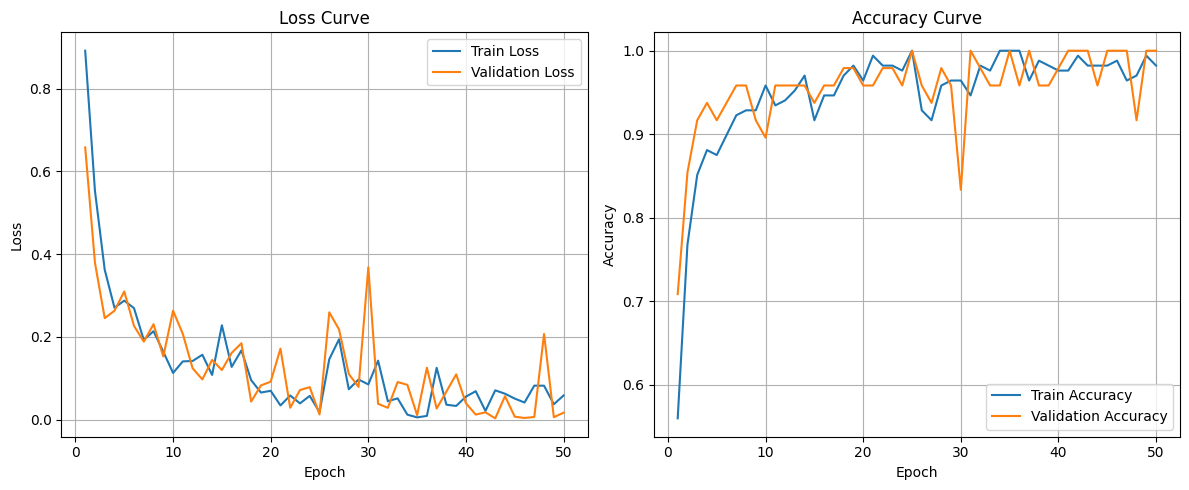

In [67]:
import matplotlib.pyplot as plt

%matplotlib inline

epochs = iter_log

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, tloss_log, label='Train Loss')
plt.plot(epochs, vloss_log, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, tacc_log, label='Train Accuracy')
plt.plot(epochs, vacc_log, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [68]:
model_path = './models/lstm_model.pth'

torch.save(net.state_dict(), model_path)
print('모델이 저장되었습니다.')

모델이 저장되었습니다.


In [22]:
model_path = './models/lstm_model.pth'

lstm_model = LSTM().to(device)
lstm_model.load_state_dict(torch.load(model_path, map_location=device))
lstm_model.eval()

length = 18
people_cls = 0
cigarette_cls = 1

lstm_model.eval()
dataset = []
status = 'None'
prev_action = None

mp_pose = mp.solutions.pose
poses = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

xyz_list_list = []
status_dict = {0: 'normal', 1: 'swoon', 2: 'smoking'}


cap = cv2.VideoCapture(2)

if not cap.isOpened():
    RuntimeError("카메라 열기 실패")

while True:
    ret, frame = cap.read()
    if not ret:  # 프레임 읽기 실패 시 종료
        break

    # 프레임 크기 조정 (선택 사항, YOLO 모델에 따라 필요)
    frame = cv2.resize(frame, (640, 640))

    # Mediapipe 포즈 추출
    results = poses.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    xyz_list = []

    if results.pose_landmarks:

        # 포즈 랜드마크 추출 및 그리기
        for landmark in results.pose_landmarks.landmark:
            xyz_list.append(landmark.x)
            xyz_list.append(landmark.y)
            xyz_list.append(landmark.z)

        # YOLO 박스 예측
        box_results = yolo_model.predict(frame, conf=0.6, verbose=False, show=False)[0].boxes
        boxes = box_results.xyxy.cpu().tolist()
        box_class = box_results.cls.cpu().tolist()

        px1, py1, px2, py2 = 0, 0, 0, 0
        cx1, cy1, cx2, cy2 = 0, 0, 0, 0
        for idx, cls in enumerate(box_class):
            if int(cls) == people_cls:
                px1, py1, px2, py2 = boxes[0]
                px1, py1, px2, py2 = int(px1), int(py1), int(px2), int(py2)

            elif int(cls) == cigarette_cls:
                cx1, cy1, cx2, cy2 = boxes[1]
                cx1, cy1, cx2, cy2 = int(cx1), int(cy1), int(cx2), int(cy2)

                break

        # YOLO 박스 좌표 정규화 후 추가
        xyz_list.extend([abs(px1 - cx1) / 640, abs(px2 - cx2) / 640, abs(py1 - cy1) / 640, abs(py2 - cy2) / 640])
        xyz_list_list.append(xyz_list)

    # 시퀀스 길이에 도달하면 LSTM 예측 수행
    if len(xyz_list_list) == length:
        dataset = [{'key': 0, 'value': xyz_list_list}]  # 임시 라벨 0 사용
        dataset = MyDataset(dataset)
        dataset_loader = DataLoader(dataset, batch_size=1)

        for data, _ in dataset_loader:
            data = data.to(device)
            with torch.no_grad():
                result = lstm_model(data)
                _, out = torch.max(result, 1)
                status = status_dict.get(out.item(), 'Unknown')

        xyz_list_list = []  # 시퀀스 초기화

    # 상태 텍스트 표시
    cv2.putText(frame, status, (10, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255, 0, 0), 2)

    # 프레임 표시
    cv2.imshow('frame', frame)

    # 'q' 키로 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 리소스 해제
cap.release()
cv2.destroyAllWindows()

I0000 00:00:1746618563.107754  241334 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746618563.120959  244964 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1746618563.420323  244952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746618563.597130  244960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[ WARN:0@1481.343] global cap_v4l.cpp:803 requestBuffers VIDEOIO(V4L2:/dev/video2): failed VIDIOC_REQBUFS: errno=19 (No such device)
